In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [3]:
import torch
torch.cuda.is_available()

True

In [0]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=45, is_inception=False):
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
               
            else:
                model.eval()   # Set model to evaluate mode 
            
            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            print(dataloaders)
            for inputs, labels in (dataloaders[phase]):         #image in inputs .. 9 vectors in label  
                inputs = inputs.to(device)
                labels = labels.to(device)              
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                   
                    if is_inception and phase == 'train':
                        
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        loss.backward()
                        optimizer.step()
                    
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc =  running_corrects.float() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.2f}m {:.2f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history


In [0]:
feature_extract= False

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [6]:
model_name= "inception"
feature_extract= False
num_classes=9
def initialize_model(model_name, num_classes, feature_extract):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    
    input_size = 299

    if model_name == "inception":
        
        model_ft = models.inception_v3(pretrained=True, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)  #changed from num_classes
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)           #changed from num_classes
        
        model_ft.AuxLogits.fc = nn.Linear(768, num_classes)
        model_ft.fc = nn.Linear(2048, num_classes)


    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

    # Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract)

# Print the model we just instantiated
print(model_ft)

        

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:02<00:00, 48.0MB/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
train_path= '/content/drive/My Drive/Project DIVP/places/train'
test_path = '/content/drive/My Drive/Project DIVP/places/test'
path={'train':'/content/drive/My Drive/Project DIVP/places/train','test':'/content/drive/My Drive/Project DIVP/places/test'}
data_transforms = {
    'train': transforms.Compose([
        #transforms.CenterCrop(10),                         
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_dataset = {x:datasets.ImageFolder(path[x], data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x:torch.utils.data.DataLoader(image_dataset[x], batch_size=8, shuffle=True, num_workers=2) for x in ['train', 'test']}

classes = ('abbey', 'airpot_terminal', 'alley', 'amphittheater', 'amusement_park'
           'aquarium', 'aqueduct', 'arch', 'art_gallery')


# New Section

In [0]:
params_to_update = model_ft.parameters()


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-4, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device) #send the model to the gpu
model_name="inception"

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, device, num_epochs=45, is_inception=(model_name=="inception") )


Epoch 0/44
----------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6ee1ddd8>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6edb7160>}
train Loss: 2.9757 Acc: 0.1816
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6ee1ddd8>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6edb7160>}
test Loss: 2.0111 Acc: 0.4114

Epoch 1/44
----------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6ee1ddd8>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6edb7160>}
train Loss: 2.6040 Acc: 0.4029
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6ee1ddd8>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6edb7160>}
test Loss: 1.7800 Acc: 0.6458

Epoch 2/44
----------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6ee1ddd8>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f4d6edb7160>}
train Loss: 2.2615 Acc: 0.5595
{'train': <torch.ut

In [0]:
torch.save(model_ft, '/content/drive/My Drive/Project DIVP/finetune.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Inception3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BasicConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/pyt

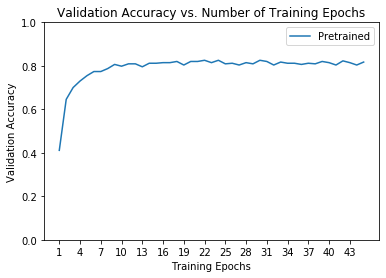

In [0]:
ohist = []
num_epochs=45

ohist = [h.cpu().numpy() for h in hist]


plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 3))
plt.legend()
plt.show()

In [0]:
from PIL import Image



device = torch.device("cuda")
model=torch.load('/content/drive/My Drive/Project DIVP/finetune.pt')
model.to(device)

validation_img_paths = ["/abbey/gsun_1bf9402fc0664f0703db03d1bf7e67d0.jpg",
                        "/airport_terminal/gsun_2c25cb7b9eb4bfde90ad7b0fa8ae6e4e.jpg",
                        "/amphitheater/gsun_4f5596127ae1bd74175187bd17263824.jpg",
                        "/arch/gsun_305afd096fbf4339b579bbfc93ba3806.jpg",
                        "/aquarium/gsun_4513278a72ed0ed0d35552b2a2a3c5a1.jpg",
                        "/amusement_park/gsun_1d227b4dcfee71cc0030b631bfd7bed0.jpg"]
img_list = [Image.open(test_path + img_path) for img_path in validation_img_paths]

In [21]:
from torch.nn import functional as F
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_ft = model_ft.to(device)
validation_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in img_list])

pred_logits_tensor = model(validation_batch)
print(pred_logits_tensor)


tensor([[ 6.4790, -1.9910, -1.7835, -0.5638, -0.5002, -0.8862, -0.6728,  1.5310,
         -1.0692],
        [-2.2313,  6.6376, -1.0362, -0.4306,  1.3907, -0.2301, -1.5390, -0.7002,
          0.1785],
        [-0.9144, -0.8060, -0.1039,  4.5658,  1.0939,  0.1124,  0.3989, -1.3851,
         -1.1122],
        [ 0.9126, -1.3079, -0.5580, -0.1817, -0.2377,  0.9415,  0.1743,  0.7645,
          0.2397],
        [-1.1689, -1.1067, -1.2188, -0.5213,  0.2154,  4.7108, -0.4683, -0.1071,
         -0.3101],
        [-1.4651,  0.9875,  0.5643,  1.0534,  2.6665, -0.7916, -0.8968, -0.4121,
         -0.5118]], device='cuda:0', grad_fn=<AddmmBackward>)


In [22]:
pred_probs = torch.nn.functional.softmax(pred_logits_tensor, dim=1)
pred_probs
print(pred_probs)

tensor([[9.8881e-01, 2.0731e-04, 2.5512e-04, 8.6391e-04, 9.2065e-04, 6.2580e-04,
         7.7472e-04, 7.0179e-03, 5.2118e-04],
        [1.3928e-04, 9.8984e-01, 4.6013e-04, 8.4311e-04, 5.2103e-03, 1.0303e-03,
         2.7830e-04, 6.4387e-04, 1.5503e-03],
        [3.8513e-03, 4.2922e-03, 8.6615e-03, 9.2386e-01, 2.8693e-02, 1.0753e-02,
         1.4320e-02, 2.4052e-03, 3.1600e-03],
        [2.0536e-01, 2.2293e-02, 4.7191e-02, 6.8750e-02, 6.5006e-02, 2.1138e-01,
         9.8151e-02, 1.7709e-01, 1.0478e-01],
        [2.6747e-03, 2.8464e-03, 2.5446e-03, 5.1113e-03, 1.0678e-02, 9.5671e-01,
         5.3891e-03, 7.7338e-03, 6.3129e-03],
        [9.6056e-03, 1.1161e-01, 7.3098e-02, 1.1921e-01, 5.9824e-01, 1.8838e-02,
         1.6957e-02, 2.7533e-02, 2.4920e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


tensor(98.8813, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0139, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3851, device='cuda:0', grad_fn=<MulBackward0>)
tensor(20.5363, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2675, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9606, device='cuda:0', grad_fn=<MulBackward0>)


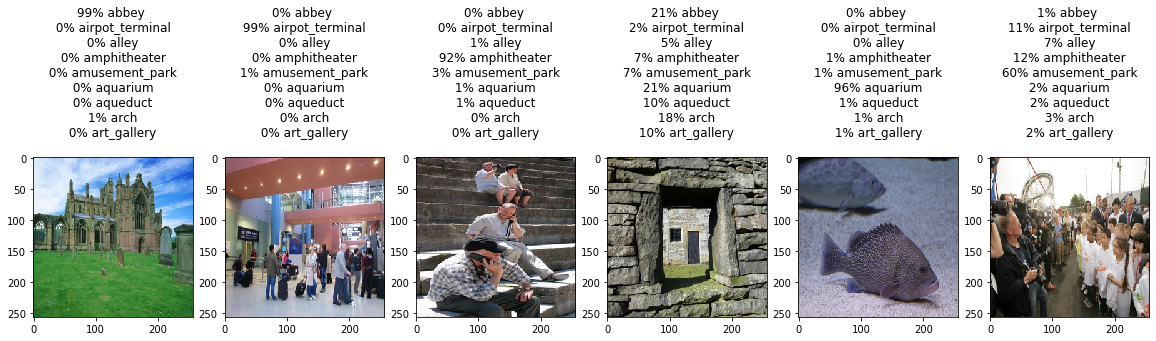

In [23]:
import pandas as pd
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    
    #print(d.loc[:,0:0]) 
    print(100*pred_probs[i,0])
    ax.set_title("{:.0f}% abbey \n {:.0f}% airpot_terminal \n {:.0f}% alley \n {:.0f}% amphitheater \n {:.0f}% amusement_park \n {:.0f}% aquarium \n {:.0f}% aqueduct \n {:.0f}% arch \n {:.0f}% art_gallery \n".format( 100*pred_probs[i,0],
                                                                                                                                                                                                                         100*pred_probs[i,1],
                                                                                                                                                                                                                         100*pred_probs[i,2],
                                                                                                                                                                                                                         100*pred_probs[i,3],
                                                                                                                                                                                                                         100*pred_probs[i,4],
                                                                                                                                                                                                                         100*pred_probs[i,5],
                                                                                                                                                                                                                         100*pred_probs[i,6],
                                                                                                                                                                                                                         100*pred_probs[i,7],
                                                                                                                                                                                                                         100*pred_probs[i,8]))
    

    ax.imshow(img)

Normalized confusion matrix
[[0.675      0.         0.         0.05       0.         0.
  0.125      0.15       0.        ]
 [0.         0.92682927 0.         0.         0.02439024 0.
  0.         0.         0.04878049]
 [0.02439024 0.         0.87804878 0.         0.         0.02439024
  0.02439024 0.04878049 0.        ]
 [0.         0.         0.         0.95121951 0.04878049 0.
  0.         0.         0.        ]
 [0.025      0.025      0.05       0.         0.85       0.025
  0.         0.025      0.        ]
 [0.         0.         0.         0.         0.         0.97560976
  0.         0.         0.02439024]
 [0.         0.         0.04878049 0.02439024 0.         0.
  0.80487805 0.12195122 0.        ]
 [0.2195122  0.12195122 0.09756098 0.02439024 0.         0.02439024
  0.07317073 0.43902439 0.        ]
 [0.         0.02439024 0.02439024 0.         0.02439024 0.
  0.         0.         0.92682927]]


<Figure size 1440x720 with 0 Axes>

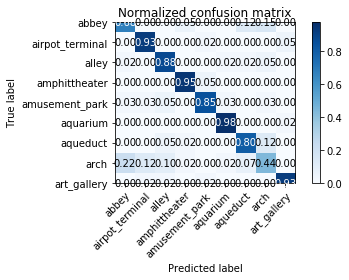

In [24]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
nb_classes = 9
c=[]
confusion_matrix = torch.zeros(nb_classes, nb_classes)

def plot_confusion_matrix(cm,y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        c.append(classes)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # print(preds)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
cm=np.asarray(confusion_matrix)
cm=cm.astype(int)    
plt.figure(figsize=(20,10))
# plt.tight_layout(pad=2,h_pad=4, w_pad=3, rect=(0,0,5,5))
plot_confusion_matrix(cm,c,preds, classes=['abbey', 'airpot_terminal', 'alley', 'amphittheater','amusement_park',
           'aquarium', 'aqueduct', 'arch', 'art_gallery'],normalize=True)
plt.show()


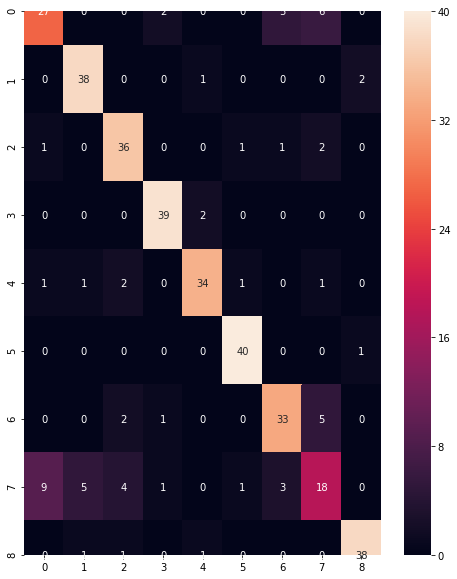

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cm
  
df_cm = pd.DataFrame(array)
plt.figure(figsize = (8,10))
plt.tight_layout()
sn.heatmap(df_cm, annot=True)